<a href="https://colab.research.google.com/github/MarkIFriemdan/hse-ftiad-thesis-bayesian-neural-networks-for-derivatives-valuation-approximation/blob/main/BSM_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Black-Scholes model

This is a simple example of learning the valuation function of a plain-vanilla put option in 5 dimensions:
* **K** – Strike price (the strike price of the option, also known as the exercise price.)
* **S** – Spot price
* **T** – Time to maturity (time of option expiration)
* **Vol** – Volatility ($\sigma$)
* **r**  – Discount rate (the annualized risk-free interest rate, continuously compounded Also known as the force of interest)
* **q** - Dividend rate 

Due to the obvious scalability of the model, the Strike price is fixed at $1.
Using this code, the user should be able to achieve the average accuracy of about 0.1 cent. 

The network architecture is a fully connected MLP with four hidden layers with 100 ReLU neurons each.

The code will detect and run on GPU (if available) or CPU.

In [ ]:
!wget 

In [ ]:
import numpy as np
from scipy.stats import norm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from BlackScholes import *

## Define Black Scholes put model

$$d_1 = \dfrac{\log(S/K) + (r - q + \sigma^2 / 2)\cdot T}{\sigma\cdot \sqrt{T}}$$
$$d_2 = d_1 - \sigma \cdot \sqrt{T}$$

$${\frac  {\partial C}{\partial T}} = -{\frac {SN'(d_{1})\sigma }{2{\sqrt {T}}}}-rKe^{-r(T)}N(d_{2})$$

In [ ]:
def ds(K, S, T, vol, r, q=0):
    vol_T = vol * np.sqrt(T)
    d1 = (np.log(S/K) + (r - q + 0.5 * vol * vol) * T) / vol_T
    d2 = d1 - vol_T
    return d1, d2

def put(K, S, T, vol, r, q=0):

    disc = np.exp(-r * T)
    pv_K = K * disc
    spot_after_div = S * np.exp(-q * T)

    d1, d2 = ds(K, S, T, vol, r, q)
    v = norm.cdf(-d2) * pv_K - norm.cdf(-d1) * spot_after_div
    return v

v_put = np.vectorize(put)

def call(K, S, T, vol, r, q=0):
    disc = np.exp(-r * T)
    pv_K = K * disc
    spot_after_div = S * np.exp(-q * T)

    d1, d2 = ds(K, S, T, vol, r, q)
    c = norm.cdf(d1) * spot_after_div - norm.cdf(d2) * pv_K
    return c

def greeks(K, S, T, vol, r, q=0):
    disc = np.exp(-r * T)
    pv_K = K * disc
    d1, d2 = ds(K, S, T, vol, r, q)
    delta = norm.cdf(d1)
    teta = - S * norm.pdf(d1) * vol / (2 * np.sqrt(T)) - r * pv_K * norm.cdf(d2)
    vega = S * norm.pdf(d1) * np.sqrt(T)
    rho = pv_K * norm.cdf(d2) * T

    return np.array([delta, teta, vega, rho])



v_call = np.vectorize(call)
v_greeks = np.vectorize(greeks)

In [ ]:
v_greeks(40, 42, 0.5, 0.2, 0.1, 0)

array([ 0.77913129, -4.55909219,  8.81341506, 13.98204591])

In [ ]:
class DataGen():
    def __init__(self, domain={
            "spot": (0.5, 2),
            "time": (0, 3.0),
            "sigma": (0.1, 0.5),
            "rate": (-0.01, 0.03)
        }):
       self.domain = domain
        
    def generate_train_test(self, train_size = 10 ** 3, test_size=0.2):
        import numpy as np
        from sklearn.model_selection import train_test_split

        if test_size <= 1:
            test_size = int(test_size * train_size)
        else:
            test_size = test_size
        domain = self.domain

        n_samples = train_size + test_size

        x = np.zeros(shape=(len(domain.keys()), n_samples))
        for i, r in enumerate(domain.values()):
            x[i] = np.random.uniform(r[0], r[1], n_samples)
        
        y = v_put(K=1, S=x[0], T=x[1], vol=x[2], r=x[3])
        dydx = v_greeks(K=1, S=x[0], T=x[1], vol=x[2], r=x[3])
        print(type(x), type(y), type(dydx))
        x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(
        x, y, dydx, test_size=test_size, random_state=42)
        
        return [x_train, y_train, z_train], [x_test, y_test, z_test]
        


In [ ]:
dg = DataGen()
train, test = dg.generate_train_test()

ValueError: ignored

In [ ]:
call(40, 42, 0.5, 0.2, 0.1, 0)

4.759422392871532

## Generate train, test, and validation data

In [ ]:
# Fix seeds for reproducibility
seed = 314
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
# Training domain
domain = {
    "spot": (0.5, 2),
    "time": (0, 3.0),
    "sigma": (0.1, 0.5),
    "rate": (-0.01, 0.03)
}

In [ ]:
n_samples = 100         # Total number of samples
pct_test = 0.2              # Portion for test set
pct_validation = 0.1        # Portion for validation set

samples = np.zeros(shape=(len(domain.keys()), n_samples))
for i, r in enumerate(domain.values()):
    samples[i] = np.random.uniform(r[0], r[1], n_samples)

In [ ]:
# %%time

#### Calculate BSM values
values = v_put(K=1, S=samples[0], T=samples[1], vol=samples[2], r=samples[3])
values_g = v_greeks(K=1, S=samples[0], T=samples[1], vol=samples[2], r=samples[3])

ValueError: ignored

In [ ]:
samples_t = torch.from_numpy(samples.T).float()
values_t = torch.from_numpy(values).float().unsqueeze(dim=1)
values_t2 = torch.from_numpy(values_2).float().unsqueeze(dim=1)

NameError: ignored

## Define DNN architecture and learning function

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_layers, n_output):
        super(Net, self).__init__()

        self.n_hidden = n_hidden
        self.n_layers = n_layers

        self.linears = torch.nn.ModuleList([torch.nn.Linear(n_feature, n_hidden)])
        self.linears.extend([torch.nn.Linear(n_hidden, n_hidden) for i in range(1, n_layers)])
        self.linears.append(torch.nn.Linear(n_hidden, n_output))

    def forward(self, x):
        for lin in self.linears:
            x = F.relu(lin(x))       # Activation function for all layers (prices can't be negative)
        return x

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
  samples_t, values_t, test_size=pct_test, random_state=42)
    
x_train, x_validation, y_train, y_validation = train_test_split(
  x_train, y_train, test_size=pct_validation*(1-pct_test), random_state=42)
    

In [ ]:
def fit_net(net: Net, n_epochs: int, x: torch.tensor, y: torch.tensor,
            pct_test: int, pct_validation: int, device: str='cpu'):

    n = y.size()[0]
    n_train = x_train.shape[0]
    n_test = x_test.shape[0]
    
    net.to(device)
    x_ = x_train.to(device)
    y_ = y_train.to(device)

    x_test_ = x_test.to(device)
    y_test_ = y_test.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    loss_func = torch.nn.MSELoss()
   
    l = 10**5
    best_l = 1e-3
    checkpoint = {}
    l_train = []
    l_test = []

    
    for e in range(n_epochs):
        prediction = net(x_)
        loss = loss_func(prediction, y_)
        l_train.append(loss.data.cpu().numpy())

        prediction_test = net(x_test_)
        loss_test = loss_func(prediction_test, y_test_)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        l = loss_test.data.cpu().numpy()
        l_test.append(l)
        if l.item() < best_l:
            best_l = l.item()
            checkpoint = {
                "n_hidden": net.n_hidden,
                "n_layers": net.n_layers,
                "model_state_dict": net.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }
        if (e + 1) % 100 == 0:
            print(f"\tEpoch: {e+1}\tL2 Loss = {loss.data.cpu().numpy()}")

    return best_l, checkpoint, l_train, l_test

## Determine device

In [ ]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    print(f"GPU detected. Running on {device}")
else:
    print("No GPU detected. Running on CPU")

GPU detected. Running on cuda:0


## Define network architecture and train

In [ ]:
net = Net(n_feature=5, n_hidden=100, n_layers=4, n_output=1)  # define the network
print(net)  # net architecture

Net(
  (linears): ModuleList(
    (0): Linear(in_features=5, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [ ]:
%%time

n_epochs = 1000
ls, checkpoint, l_train, l_test = fit_net(net, n_epochs, samples_t, values_t, pct_test, pct_validation, device)
print(f"Best loss ={ls}")

	Epoch: 100	L2 Loss = 0.0001027706457534805
	Epoch: 200	L2 Loss = 6.37382036074996e-05
	Epoch: 300	L2 Loss = 1.6041500202845782e-05
	Epoch: 400	L2 Loss = 9.951443644240499e-06
	Epoch: 500	L2 Loss = 9.052893801708706e-06
	Epoch: 600	L2 Loss = 9.002421575132757e-05
	Epoch: 700	L2 Loss = 5.370746748667443e-06
	Epoch: 800	L2 Loss = 5.723204594687559e-06
	Epoch: 900	L2 Loss = 3.4659633456612937e-06
	Epoch: 1000	L2 Loss = 3.190176812495338e-06
Best loss =3.188519485775032e-06
CPU times: user 31.8 s, sys: 1.15 s, total: 33 s
Wall time: 38.7 s


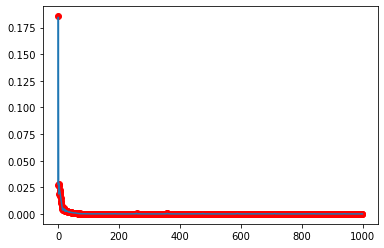

In [ ]:
plt.scatter(range(n_epochs), l_train, c='r')
plt.plot(range(n_epochs), l_test)
plt.show()

In [ ]:
l_train = np.array(l_train)
l_test = np.array(l_test)
(np.abs(l_train - l_test)).sum()

0.0057644295

## Make copy of network from checkpoint and validate results

In [ ]:
model = Net(n_feature=5,
            n_hidden=checkpoint["n_hidden"],
            n_layers=checkpoint["n_layers"],
            n_output=1)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.to(device)

Net(
  (linears): ModuleList(
    (0): Linear(in_features=5, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [ ]:
%%time

y_pred = model(samples_t.to(device))

CPU times: user 1.71 ms, sys: 2.02 ms, total: 3.73 ms
Wall time: 4.64 ms


In [ ]:
n = values_t.size()[0]
ind_validation = n_train = int(np.round(n * (1 - pct_validation)))
samples_validation = samples_t[ind_validation:].to(device)
values_validation = values_t[ind_validation:]

In [ ]:
v_nn = model(samples_validation).flatten().data.cpu().numpy()
error = v_nn - values_validation.flatten().data.cpu().numpy()
mean_err = np.mean(error)
std_error = np.std(error)

Mean error = 0.0003, StDev = 0.0018


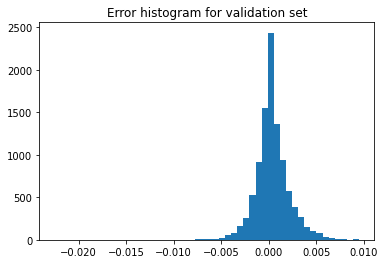

In [ ]:
plt.hist(error, bins=50)
plt.title("Error histogram for validation set")
print(f"Mean error = {mean_err:.4f}, StDev = {std_error:.4f}")

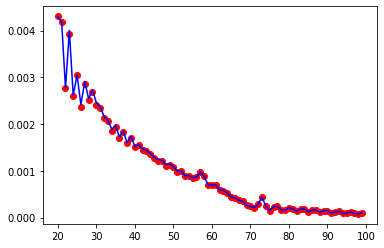

In [ ]:
plt.scatter(range(20, 100), l_train[20:100], color="r")
plt.plot(range(20, 100), l_test[20:100], color="b")

plt.show()

In [ ]:
all_train = []
all_test = []
labels = []
for nh in [100, 200, 300]:
  for nl in [4, 5, 6]:
    labels.append(f"{nl} layers, {nh} neurons")
    net = Net(n_feature=5, n_hidden=nh, n_layers=nl, n_output=1)
    n_epochs = 100
    ls, checkpoint, l_train, l_test = fit_net(net, n_epochs, samples_t, values_t, pct_test, pct_validation, device)
    all_train.append(l_train)
    all_test.append(l_test)

print(f"Best loss ={ls}")

	Epoch: 100	L2 Loss = 0.03801465407013893
	Epoch: 100	L2 Loss = 0.00041951832827180624
	Epoch: 100	L2 Loss = 0.0005495559889823198
	Epoch: 100	L2 Loss = 0.00045168204815126956
	Epoch: 100	L2 Loss = 0.03801465407013893
	Epoch: 100	L2 Loss = 0.0007395679713226855
	Epoch: 100	L2 Loss = 0.03801465407013893
	Epoch: 100	L2 Loss = 0.0006492187967523932
	Epoch: 100	L2 Loss = 0.03801465407013893
Best loss =0.001


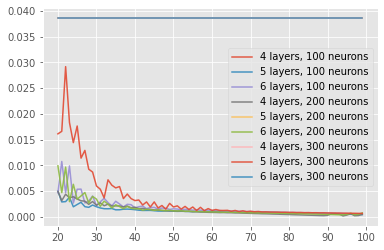

In [ ]:
plt.style.use('ggplot')
for i in range(len(all_train)):
    # plt.scatter(range(20, 100), all_train[i][20:100], alpha=0.2)
    plt.plot(range(20, 100), all_test[i][20:100], label=labels[i], alpha=0.9)
    plt.legend()
plt.show()

